In [61]:
import lmdb
from collections import defaultdict
import math
import matplotlib.pyplot as plt
from collections import defaultdict
import pickle
import torch

In [64]:
# Function to retrieve worst force rows for a given system and epoch
def get_worst_force_rows(env, system_id, epoch):
    """Retrieve worst force rows for a given system and epoch."""
    with env.begin() as txn:
        key = f"{system_id}_{epoch}".encode()
        value = txn.get(key)
        if value:
            return pickle.loads(value).tolist()  # Convert back from bytes
    return None  # No data found
    
def list_lmdb_keys(env):
    """Lists all keys in the LMDB database."""
    with env.begin() as txn:
        cursor = txn.cursor()
        keys = [key.decode() for key, _ in cursor]
    return keys
def get_epoch_to_sys_dict(keys): # takes in list of keys in the lmdb
    key_dict = defaultdict(list)
    for key in keys:
        system_id, epoch = key.split("_")
        if not float(epoch).is_integer():
            continue
        true_epoch = math.floor(float(epoch))
        key_dict[true_epoch].append(int(system_id))
    return key_dict

def get_sys_to_epoch_dict(keys):
    # Organize keys by system and epoch
    key_dict = defaultdict(list)
    for key in keys:
        try:
            system_id, epoch = key.split("_")
            if not float(epoch).is_integer():
                continue
            true_epoch = math.floor(float(epoch))
            key_dict[int(system_id)].append(true_epoch)
        except ValueError:
            continue  # Skip malformed keys
    key_dict[system_id].sort()
    return key_dict



In [43]:
lmdb_path = '../student_checkpoints/worst_rows/gem_solvated_worst_corrected.lmdb'
env = lmdb.open(lmdb_path, readonly=True, lock=False)

In [44]:
keys = list_lmdb_keys(env)
sys_to_epoch = get_sys_to_epoch_dict(keys)
epoch_to_sys = get_epoch_to_sys_dict(keys)

ValueError: x and y must have same first dimension, but have shapes (94258,) and (94358,)

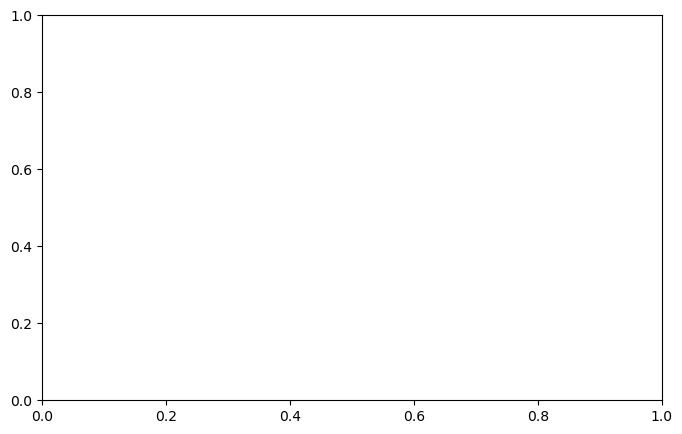

In [74]:
system_id = '9054'
ref_worst_rows = get_worst_force_rows(env, system_id, 5)  # Baseline worst rows
ref_set = set(ref_worst_rows)

epoch_fractions = [0 for _ in range(0, 500, 5)]
valid_epochs = []  # Track actual epochs
for system_id in sys_to_epoch.keys():
    for epoch in range(0, 500, 5):
        worst_rows = get_worst_force_rows(env, system_id, epoch)
        if worst_rows is None:
            continue
        common_fraction = len(set(worst_rows) & ref_set) / len(ref_set)
        epoch_fractions.append(common_fraction)
        valid_epochs.append(epoch)  # Append only valid epochs
        
epoch_fractions = [item / len(sys_to_epoch.keys()) for item in epoch_fractions]
# Plot with valid_epochs instead of range(0, 1000, 5)
plt.figure(figsize=(8, 5))
plt.plot(valid_epochs, epoch_fractions, marker='o', linestyle='-')
plt.xlabel("Epoch")
plt.ylabel("Fraction of Common Worst Rows (vs Epoch 5)")
plt.title("Stability of Worst Rows Across Epochs")
plt.grid(True)
plt.show()

In [78]:
print(sys_to_epoch.keys())
print(len(sys_to_epoch.keys()))

dict_keys([10035, 100655, 102182, 103933, 105668, 105848, 106478, 10693, 108974, 109578, 109908, 114085, 11458, 115149, 11544, 115990, 116055, 116870, 117426, 11781, 123304, 123585, 124026, 124582, 124604, 125292, 126154, 126639, 127122, 128627, 12882, 129201, 12977, 131567, 131657, 132488, 132540, 132944, 133508, 135620, 139801, 140086, 144679, 145159, 145227, 148348, 149966, 150845, 151401, 151892, 152425, 153912, 155425, 15657, 156632, 157214, 158166, 158532, 158641, 158645, 159010, 159838, 160129, 160421, 160724, 162201, 162271, 162557, 162794, 164396, 165337, 165735, 165936, 166893, 167376, 168572, 169794, 170888, 171614, 171753, 172323, 172449, 172577, 172623, 174744, 176139, 177152, 178633, 179920, 180677, 181343, 18231, 18237, 183110, 183702, 183952, 184071, 184875, 185097, 185315, 185912, 186167, 186543, 186784, 187403, 189367, 189501, 189551, 192884, 194551, 194721, 194739, 195854, 196851, 197374, 197864, 19854, 19864, 198792, 199696, 199772, 199931, 200887, 201179, 202298, 2

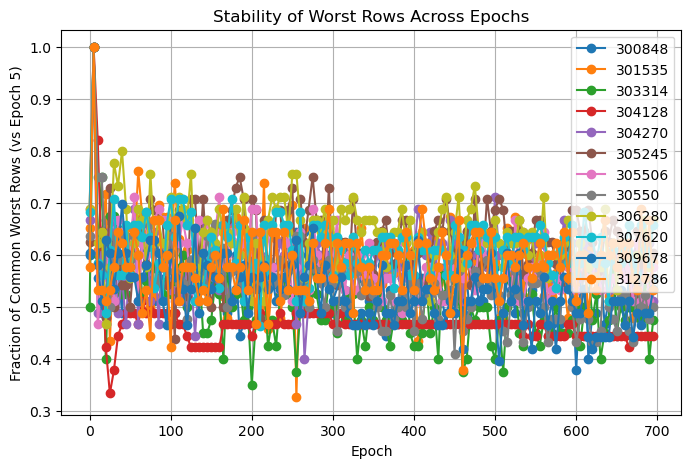

In [87]:
# system_id = '811805'
system_ids = [300848, 301535, 303314, 304128, 304270, 305245, 305506, 30550, 306280, 307620, 309678, 312786]
 # Plot with valid_epochs instead of range(0, 1000, 5)
plt.figure(figsize=(8, 5))
for sid in system_ids:
    
    ref_worst_rows = get_worst_force_rows(env, sid, 5)  # Baseline worst rows
    ref_set = set(ref_worst_rows)
    
    epoch_fractions = []
    valid_epochs = []  # Track actual epochs
    
    for epoch in range(0, 698, 5):
        worst_rows = get_worst_force_rows(env, sid, epoch)
        if worst_rows is None:
            continue
        common_fraction = len(set(worst_rows) & ref_set) / len(ref_set)
        epoch_fractions.append(common_fraction)
        valid_epochs.append(epoch)  # Append only valid epochs
    
   
    plt.plot(valid_epochs, epoch_fractions, marker='o', linestyle='-', label=sid,)
    
plt.xlabel("Epoch")
plt.ylabel("Fraction of Common Worst Rows (vs Epoch 5)")
plt.title("Stability of Worst Rows Across Epochs")
plt.grid(True)
plt.legend()
plt.show()


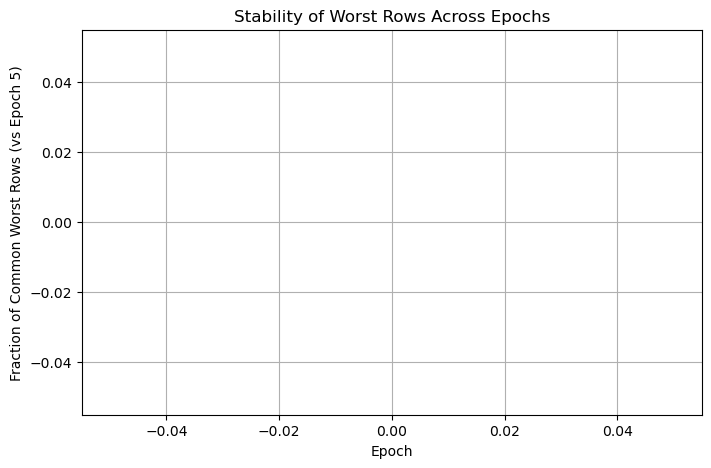

In [47]:
# Compute fraction of common worst rows relative to epoch 5
epoch_fractions = defaultdict(list)

for system_id, epochs in key_dict.items():
    if 5 not in epochs:
        continue  # Skip if epoch 5 data is missing
    
    ref_worst_rows = get_worst_force_rows(env, system_id, 5)  # Baseline worst rows
    if ref_worst_rows is None:
        continue  # Skip if reference data is missing

    ref_set = set(ref_worst_rows)

    for epoch in epochs:
        worst_rows = get_worst_force_rows(env, system_id, epoch)
        if worst_rows is None:
            continue

        common_fraction = len(set(worst_rows) & ref_set) / max(len(ref_set), 1)
        epoch_fractions[epoch].append(common_fraction)

# Compute average fraction per epoch
epochs_sorted = sorted(epoch_fractions.keys())
avg_fractions = [np.mean(epoch_fractions[epoch]) for epoch in epochs_sorted]

# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(epochs_sorted, avg_fractions, marker='o', linestyle='-')
plt.xlabel("Epoch")
plt.ylabel("Fraction of Common Worst Rows (vs Epoch 5)")
plt.title("Stability of Worst Rows Across Epochs")
plt.grid(True)
plt.show()